<a href="https://colab.research.google.com/github/moo0la/final_peoject/blob/main/ML_Bitcoin_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!pip install arch

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")
import arch


In [84]:
url = 'https://api.binance.com/api/v3/klines'



r = requests.get(url,params={'symbol':'BTCUSDT','interval': '1d','limit':2000})
r


<Response [200]>

In [85]:
collumns = """

1499040000000,      // Open time
    "0.01634790",       // Open
    "0.80000000",       // High
    "0.01575800",       // Low
    "0.01577100",       // Close
    "148976.11427815",  // Volume
    1499644799999,      // Close time
    "2434.19055334",    // Quote asset volume
    308,                // Number of trades
    "1756.87402397",    // Taker buy base asset volume
    "28.46694368",      // Taker buy quote asset volume
    "17928899.62484339" // Ignore.

""".split("//")[1:-1]


my_col_names = [sub_str.split('\n')[0].lower().strip().replace(' ','_') for sub_str in collumns]
# my_col_names.insert(0, 'timestamp')
my_col_names.append('ignore')
my_col_names

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_asset_volume',
 'taker_buy_quote_asset_volume',
 'ignore']

In [86]:
df = pd.DataFrame(r.json(),columns = my_col_names)
df.index = pd.to_datetime(df.open_time*1000000)
#df.index = pd.DatetimeIndex(df.open_time*1000000)
df.index.name = 'Date'
df = df.drop(columns=['open_time','close_time','ignore'])
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
Date,,,,,,,,,
2019-04-18,5202.41000000,5287.00000000,5198.80000000,5258.44000000,22619.23900100,118573129.86520114,167110,12104.85293200,63464128.54331125
2019-04-19,5258.44000000,5320.00000000,5175.00000000,5258.68000000,24611.23632300,128937309.63806376,178148,12889.68334400,67549701.12506344
2019-04-20,5258.68000000,5333.42000000,5230.10000000,5291.73000000,19168.90827400,101343660.15324434,157080,10029.27226200,53029542.91017945
2019-04-21,5292.91000000,5314.35000000,5165.00000000,5256.14000000,25549.57093900,133929931.15068736,210494,13147.77101600,68909870.81367928
2019-04-22,5257.41000000,5400.00000000,5208.35000000,5357.14000000,29563.85230900,156632202.97099613,210361,15828.00485100,83879362.28322349
...,...,...,...,...,...,...,...,...,...
2022-01-07,43082.30000000,43145.83000000,40610.00000000,41566.48000000,54836.50818000,2293851015.46523690,1406635,26519.39261000,1109740200.23872120
2022-01-08,41566.48000000,42300.00000000,40501.00000000,41679.74000000,32952.73111000,1367233494.82776660,1021908,16462.53747000,683155535.42153480
2022-01-09,41679.74000000,42786.70000000,41200.02000000,41864.62000000,22724.39426000,952830064.51258490,752733,11399.78979000,478046850.27715200


In [87]:
r = requests.get(url,params={'symbol':'BTCUSDT','interval': '1d','limit':2000,'endTime':(1641348720-1)*2000})
pd.DatetimeIndex(pd.DataFrame(r.json(),columns = my_col_names).open_time*1000000)

DatetimeIndex(['2019-04-18', '2019-04-19', '2019-04-20', '2019-04-21',
               '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25',
               '2019-04-26', '2019-04-27',
               ...
               '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09',
               '2022-01-10', '2022-01-11'],
              dtype='datetime64[ns]', name='open_time', length=1000, freq=None)

In [88]:
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [89]:
df['taker_sell_base_asset_volume'] = df.volume - df.taker_buy_base_asset_volume
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume
Date,,,,,,,,,,
2019-04-18,5202.41,5287.00,5198.80,5258.44,22619.239001,1.185731e+08,167110,12104.852932,6.346413e+07,10514.386069
2019-04-19,5258.44,5320.00,5175.00,5258.68,24611.236323,1.289373e+08,178148,12889.683344,6.754970e+07,11721.552979
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923
2019-04-22,5257.41,5400.00,5208.35,5357.14,29563.852309,1.566322e+08,210361,15828.004851,8.387936e+07,13735.847458
...,...,...,...,...,...,...,...,...,...,...
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640
2022-01-09,41679.74,42786.70,41200.02,41864.62,22724.394260,9.528301e+08,752733,11399.789790,4.780469e+08,11324.604470


In [90]:
df['order_flow_imbalance'] = 1-(df.taker_sell_base_asset_volume/df.taker_buy_base_asset_volume)
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume,order_flow_imbalance
Date,,,,,,,,,,,
2019-04-18,5202.41,5287.00,5198.80,5258.44,22619.239001,1.185731e+08,167110,12104.852932,6.346413e+07,10514.386069,0.131391
2019-04-19,5258.44,5320.00,5175.00,5258.68,24611.236323,1.289373e+08,178148,12889.683344,6.754970e+07,11721.552979,0.090625
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012,0.088704
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923,0.056737
2019-04-22,5257.41,5400.00,5208.35,5357.14,29563.852309,1.566322e+08,210361,15828.004851,8.387936e+07,13735.847458,0.132181
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570,-0.067789
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640,-0.001680
2022-01-09,41679.74,42786.70,41200.02,41864.62,22724.394260,9.528301e+08,752733,11399.789790,4.780469e+08,11324.604470,0.006595


In [91]:
df['price_change'] = df.close.pct_change()
df = df.dropna()
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume,order_flow_imbalance,price_change
Date,,,,,,,,,,,,
2019-04-19,5258.44,5320.00,5175.00,5258.68,24611.236323,1.289373e+08,178148,12889.683344,6.754970e+07,11721.552979,0.090625,0.000046
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012,0.088704,0.006285
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923,0.056737,-0.006726
2019-04-22,5257.41,5400.00,5208.35,5357.14,29563.852309,1.566322e+08,210361,15828.004851,8.387936e+07,13735.847458,0.132181,0.019216
2019-04-23,5357.14,5600.00,5332.41,5493.31,41262.103917,2.271541e+08,282563,21260.014469,1.170548e+08,20002.089448,0.059169,0.025418
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570,-0.067789,-0.035185
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640,-0.001680,0.002725
2022-01-09,41679.74,42786.70,41200.02,41864.62,22724.394260,9.528301e+08,752733,11399.789790,4.780469e+08,11324.604470,0.006595,0.004436


In [92]:
df['Date']=df.index

In [93]:
#df["low"] = pd.to_numeric(df["low"])
#df["high"] = pd.to_numeric(df["high"])
#df['Mean'] = (df['low'] + df['high'])/2
#df=df.dropna()
#df

In [94]:
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['taker_sell_base_asset_volume'].shift()# to represent actual value
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,taker_sell_base_asset_volume,order_flow_imbalance,price_change,Date,Actual
Date,,,,,,,,,,,,,,
2019-04-20,5258.68,5333.42,5230.10,5291.73,19168.908274,1.013437e+08,157080,10029.272262,5.302954e+07,9139.636012,0.088704,0.006285,2019-04-20,11721.552979
2019-04-21,5292.91,5314.35,5165.00,5256.14,25549.570939,1.339299e+08,210494,13147.771016,6.890987e+07,12401.799923,0.056737,-0.006726,2019-04-21,9139.636012
2019-04-22,5257.41,5400.00,5208.35,5357.14,29563.852309,1.566322e+08,210361,15828.004851,8.387936e+07,13735.847458,0.132181,0.019216,2019-04-22,12401.799923
2019-04-23,5357.14,5600.00,5332.41,5493.31,41262.103917,2.271541e+08,282563,21260.014469,1.170548e+08,20002.089448,0.059169,0.025418,2019-04-23,13735.847458
2019-04-24,5490.91,5582.20,5333.35,5415.00,48224.152413,2.624933e+08,339599,23401.188520,1.274198e+08,24822.963893,-0.060757,-0.014256,2019-04-24,20002.089448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-07,43082.30,43145.83,40610.00,41566.48,54836.508180,2.293851e+09,1406635,26519.392610,1.109740e+09,28317.115570,-0.067789,-0.035185,2022-01-07,19611.546430
2022-01-08,41566.48,42300.00,40501.00,41679.74,32952.731110,1.367233e+09,1021908,16462.537470,6.831555e+08,16490.193640,-0.001680,0.002725,2022-01-08,28317.115570
2022-01-09,41679.74,42786.70,41200.02,41864.62,22724.394260,9.528301e+08,752733,11399.789790,4.780469e+08,11324.604470,0.006595,0.004436,2022-01-09,16490.193640


In [95]:
# normalizing exogeneous variables

from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'taker_sell_base_asset_volume']])
scaled_input = pd.DataFrame(scaled_input, index=dataset_for_prediction.index)
X= scaled_input
X.rename(columns={0:'low', 1:'high', 2:'open', 3:'close', 4:'volume', 5:'taker_sell_base_asset_volume'}, inplace=True)
print(X.head())

                 low      high  ...    volume  taker_sell_base_asset_volume
Date                            ...                                        
2019-04-20  0.023190  0.000299  ...  0.040245                      0.037802
2019-04-21  0.022147  0.000000  ...  0.056232                      0.053853
2019-04-22  0.022841  0.001345  ...  0.066291                      0.060417
2019-04-23  0.024828  0.004485  ...  0.095603                      0.091250
2019-04-24  0.024843  0.004206  ...  0.113048                      0.114971

[5 rows x 6 columns]


In [96]:
#normalizing the time series
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output, index=dataset_for_prediction.index)
y=scaler_output
y.rename(columns={0:'BTC Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
print(y.head())

            BTC Price next day
Date                          
2019-04-20            0.022842
2019-04-21            0.009768
2019-04-22            0.026287
2019-04-23            0.033042
2019-04-24            0.064774


In [97]:
# train-test split
train_size=int(len(df) *0.9)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [99]:
model= SARIMAX(train_y,
 exog=train_X,
 order=(0,1,1),
 seasonal_order =(0, 0, 1, 12),
 enforce_invertibility=False, enforce_stationarity=False)


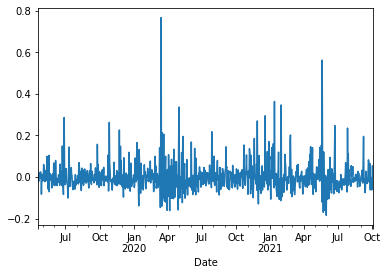

In [100]:
# training the model
results= model.fit()

# plotting residuals
results.resid.plot()

In [101]:
# making preditions
predictions= results.predict(start =train_size, end=train_size+test_size-2,exog=test_X)
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
print(predictions)
#for i in range(len(predictions)) : 
 # predictions.iloc[i,0]= predictions.iloc[i,0]+predic_garch[i]

                Pred    Actual
Date                          
2021-10-05  0.084391  0.083823
2021-10-06  0.089951  0.092301
2021-10-07  0.057806  0.162057
2021-10-08  0.060034  0.107459
2021-10-09  0.084579  0.082573
...              ...       ...
2022-01-07  0.083087  0.062796
2022-01-08  0.080928  0.106879
2022-01-09  0.069947  0.046990
2022-01-10  0.093154  0.020832
2022-01-11  0.063034  0.095524

[99 rows x 2 columns]


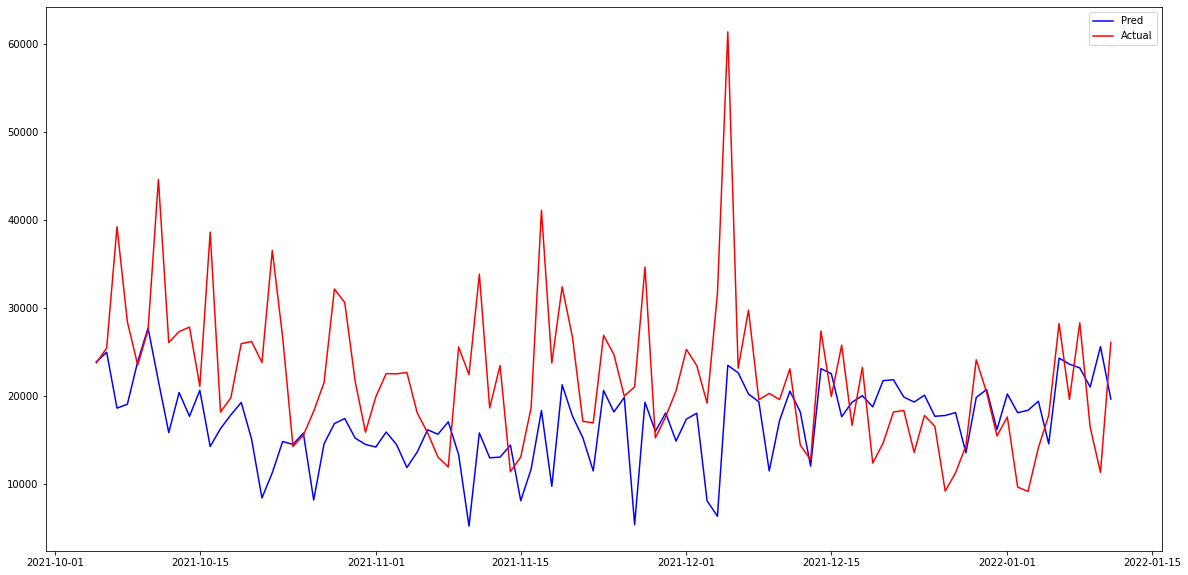

RMSE: [10009.31237815]


In [102]:
# plotting the results
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['Actual']])

plt.figure(figsize=(20,10))
plt.plot(predictions.index, trainPredict, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.legend()
plt.show()

from statsmodels.tools.eval_measures import rmse
error=rmse(trainPredict, testPredict)
print("RMSE:",error)